In [2]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import sys, os
import pickle
import matplotlib.pyplot as plt
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score,balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error, mean_absolute_error, mean_squared_error

from src.util.model import eval_model, prep_data
seed = 42

In [3]:
# dff0 = pd.DataFrame()

# data_fp = "../../data/training_data"
# training_data = os.listdir(data_fp)
# for i in range(len(training_data)):
#     # if i > 4: 
#     #     break
#     fn = training_data[i]
#     df = pd.read_csv(os.path.join(data_fp, fn))
#     print(f"{fn} {df.shape}")
#     dff0 = pd.concat([dff0, df])
# print(dff0.shape)

dff0 = pd.read_csv("../../data/training_combined/training_combined_2.csv")
dff0 = dff0[dff0['slope_angle'] > 0]

danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])

coords_geodf = gpd.read_file("../../../data/FAC/zones/grid_coords_subset.geojson")

In [4]:
exclude_cols = ['date','id_x','slope_azi', 'danger_level','altitude','slope_angle','elevation_band','lat', 'lon', 'zone_name', 'geometry','danger_level.1']
# X, y, excluded_cols = prep_data(
#     dff0, 
#     danger_levels, 
#     coords_geodf,
#     replace_missing=True, 
#     change_danger=True,
#     exclude_cols=['date','id','id_x','slope_azi', 'danger_level','altitude','slope_angle','forecast_zone_id','elevation_band','lat', 'lon', 'zone_name', 'geometry']) 

X = dff0.loc[:, ~dff0.columns.isin(exclude_cols)].copy(deep=True)
y = dff0['danger_level']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [5]:
# Params found from tuning
# {'class_weight': 'balanced', 
#  'max_depth': 50, 
#  'max_features': 0.5, 
#  'min_samples_leaf': 4, 
#  'min_samples_split': 20, 
#  'n_estimators': 1000}


rf = RandomForestClassifier(random_state=seed, n_jobs=-1,
                            max_depth=50,
                            max_features=0.5,
                            min_samples_leaf=4,
                            min_samples_split=20,
                            n_estimators=500,
                            class_weight='balanced'
                           )

# with open("../../data/models/best_model.pkl", "rb") as file:
#     rf = pickle.load(file)

In [39]:
cv = cross_val_score(rf, X_train,y_train,cv=5,n_jobs=-1)

In [40]:
for c in cv:
    print(f"{c * 100:.2f} ", end="")
print()
print(f"CV Results: Mean Accuracy - {cv.mean():.2f}% std - {cv.std():.2f}")

89.62 88.97 90.07 89.37 88.85 
CV Results: Mean Accuracy - 0.89% std - 0.00


In [6]:
rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,50
,min_samples_split,20
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Train
Accuracy 0.98
Balanced Accuracy 0.99
MAE: 0.019003520956928567
Test
Accuracy 0.92
Balanced Accuracy 0.93
MAE: 0.09194583036350677
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2053
           1       0.92      0.91      0.91      8632
           2       0.92      0.91      0.91     11526
           3       0.91      0.92      0.91      4446

    accuracy                           0.92     26657
   macro avg       0.92      0.93      0.93     26657
weighted avg       0.92      0.92      0.92     26657



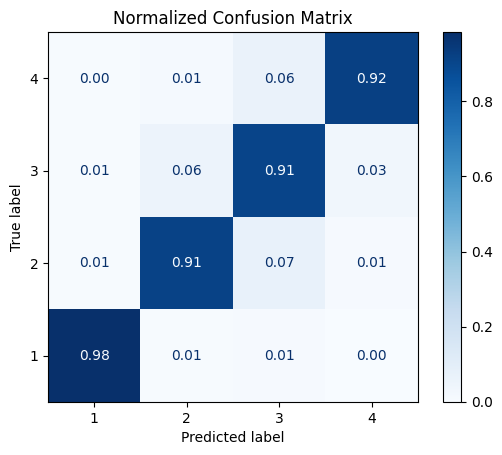

In [7]:
y_pred = rf.predict(X_test)

print("Train")
eval_model(y_train, rf.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True, cr=True)

In [9]:
dff0.columns

Index(['Qs', 'Ql', 'Qg', 'TSG', 'Qg0', 'Qr', 'dIntEnergySnow',
       'meltFreezeEnergySnow', 'ColdContentSnow', 'OLWR', 'ILWR', 'LWR_net',
       'OSWR', 'ISWR', 'Qw', 'pAlbedo', 'mAlbedo', 'ISWR_h', 'ISWR_dir',
       'ISWR_diff', 'TA', 'TSS_mod', 'T_bottom', 'RH', 'VW', 'VW_drift', 'DW',
       'MS_Snow', 'HS_mod', 'HS_meas', 'hoar_size', 'wind_trans24', 'HN3',
       'HN6', 'HN12', 'HN24', 'HN72_24', 'PSUM24', 'ski_pen', 'SWE',
       'MS_Water', 'MS_Water_Soil', 'MS_Ice_Soil', 'MS_Wind', 'MS_Rain',
       'MS_SN_Runoff', 'MS_Surface_Mass_Flux', 'MS_Sublimation', 'MS_Evap',
       'Sclass1', 'Sclass2', 'zSd', 'Sd', 'zSn', 'Sn', 'zSs', 'Ss', 'zS4',
       'S4', 'zS5', 'S5', 'danger_level', 'id_x', 'slope_angle', 'slope_azi',
       'date', 'altitude', 'lat', 'lon', 'zone_name', 'geometry',
       'elevation_band', 'danger_level.1'],
      dtype='object')

In [15]:
# dff0[exclude_cols].iloc[X_test.index]
test_data = pd.concat([X_test,dff0[exclude_cols].loc[X_test.index]],axis=1)
# test_data = pd.concat([X_test,excluded_cols.iloc[X_test.index]],axis=1)
test_data['predicted'] = y_pred
test_data.head()

,Qs,Ql,Qg,TSG,Qg0,Qr,dIntEnergySnow,meltFreezeEnergySnow,ColdContentSnow,OLWR,...,danger_level,altitude,slope_angle,elevation_band,lat,lon,zone_name,geometry,danger_level.1,predicted
4393,24.988708,-5.474208,0.0,-7.423250,3.161292,0.0,12.392750,0.000000,-1.116167,265.281625,...,2,1601.1,38.0,middle,48.247846,-113.953233,swan,POINT (-113.95323322238364 48.24784605272457),2,2
69019,22.773375,-1.834292,0.0,0.000000,0.054458,0.0,-135.155292,-136.148625,-0.121542,283.959542,...,2,1551.4,38.0,middle,48.542347,-114.196594,whitefish,POINT (-114.19659419938895 48.542346575632486),2,2
21158,2.475208,-1.174458,0.0,-6.987375,-5.922333,0.0,-30.808292,0.000000,-2.629458,245.342542,...,1,1510.3,38.0,lower,48.295400,-114.006728,swan,POINT (-114.00672777814697 48.29539986685211),1,1
28814,-5.193917,-24.698667,0.0,0.000000,0.000042,0.0,-89.695750,-87.393750,-0.041292,284.536000,...,3,1864.4,38.0,middle,48.316792,-114.053157,swan,POINT (-114.05315709968343 48.31679179853996),3,2
2893,43.227250,-0.082833,0.0,-2.538083,0.037583,0.0,23.133208,17.882500,-2.043167,280.192667,...,1,1757.7,38.0,middle,48.243116,-113.992494,swan,POINT (-113.99249394059275 48.24311604465016),1,1


In [16]:
feature_importances = pd.DataFrame(rf.feature_importances_,index = rf.feature_names_in_, columns=["importance"]).sort_values(by="importance", ascending=False)
print(feature_importances[feature_importances['importance'] > 0].index)

Index(['mAlbedo', 'TA', 'ISWR_diff', 'ISWR_h', 'HN72_24', 'RH', 'SWE',
       'wind_trans24', 'ILWR', 'DW', 'PSUM24', 'HS_mod', 'VW', 'TSG',
       'VW_drift', 'T_bottom', 'dIntEnergySnow', 'ColdContentSnow', 'HN24',
       'OLWR', 'MS_Sublimation', 'ski_pen', 'LWR_net', 'TSS_mod', 'Qg0', 'Qs',
       'MS_Snow', 'HN3', 'Ql', 'pAlbedo', 'HN6', 'HN12', 'S4', 'Sd', 'Sclass2',
       'Ss', 'S5', 'zSn', 'zSd', 'MS_Evap', 'zS4', 'MS_Rain', 'zSs',
       'MS_Water', 'Sn', 'meltFreezeEnergySnow', 'Qr', 'ISWR', 'Qw', 'OSWR',
       'hoar_size', 'ISWR_dir', 'MS_Surface_Mass_Flux', 'MS_SN_Runoff',
       'MS_Wind'],
      dtype='object')


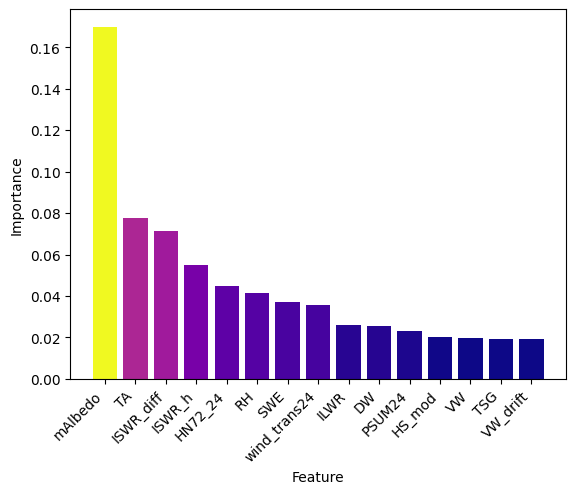

In [17]:
top = feature_importances.iloc[:15]
 
# Normalize and create colors
norm = plt.Normalize(top['importance'].min(), top['importance'].max())
cmap = plt.cm.plasma
colors = cmap(norm(top['importance']))

# Create figure and axes
fig, ax = plt.subplots()

bars = ax.bar(top.index, top['importance'], color=colors)

# Add colorbar — note the ax parameter
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Required for colorbar
# fig.colorbar(sm, ax=ax, label='Importance')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

Train
Accuracy 0.98
Balanced Accuracy 0.99
MAE: 0.019003520956928567
Test
Accuracy 0.92
Balanced Accuracy 0.93
MAE: 0.09194583036350677


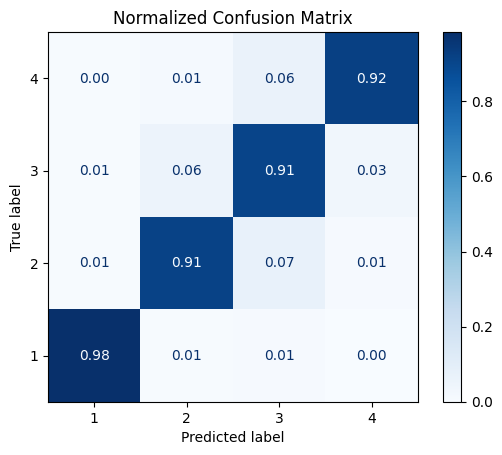

In [22]:

with open("../../data/models/best_model_2.pkl", "wb") as file:
    pickle.dump(rf, file)
    
with open("../../data/models/best_model_2.pkl", "rb") as file:
    best_model = pickle.load(file)
    
y_pred = best_model.predict(X_test)

print("Train")
eval_model(y_train, best_model.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)